In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from skimage import io
from skimage.transform import rotate
from skimage.transform import EuclideanTransform
from skimage.transform import SimilarityTransform
from skimage.transform import warp
from skimage.transform import swirl
from skimage.transform import matrix_transform
from skimage.color import rgb2gray

In [3]:
def show_comparison(original, transformed, transformed_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap='gray')
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(transformed, cmap='gray')
    ax2.set_title(transformed_name)
    ax2.axis('off')
    io.show()

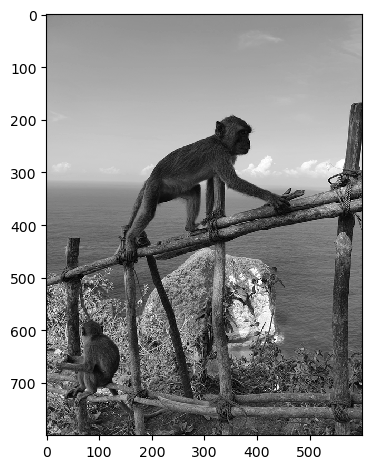

In [4]:
# Directory containing data and images
in_dir = "data/"
im_name = "NusaPenida.png"
im_org = rgb2gray(io.imread(in_dir + im_name))
io.imshow(im_org)

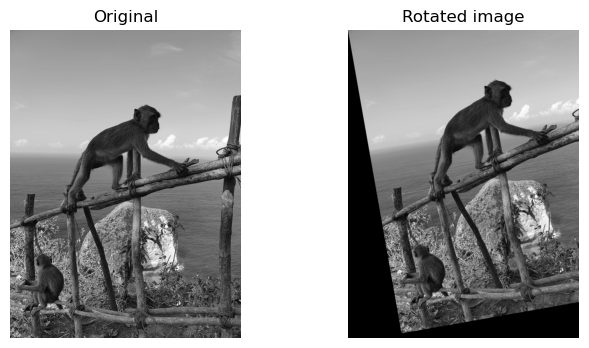

In [5]:
# angle in degrees - counter clockwise
rotation_angle = 10
rot_center = [0, 0]
rotated_img = rotate(im_org, rotation_angle, center=rot_center)
show_comparison(im_org, rotated_img, "Rotated image")

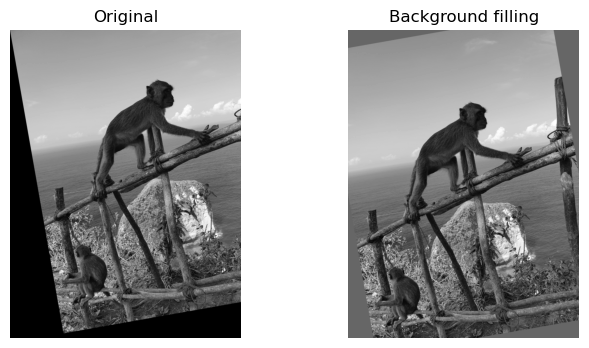

In [6]:
rotated_img_ref = rotate(im_org, rotation_angle, mode="reflect")
rotated_img_const = rotate(im_org, rotation_angle, mode='constant', cval=0.4)
show_comparison(rotated_img, rotated_img_const, 'Background filling')

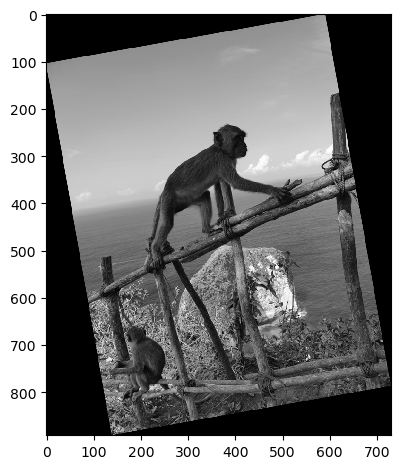

In [7]:
rotated_img = rotate(im_org, rotation_angle, resize=True)
io.imshow(rotated_img)

## Euclidean image transformation

An alternative way of doing geometric image transformations is to first construct the transformation and then apply it to the image. We will start by the **Euclidean** image transformation that consists of a rotation and a translation. It is also called a *rigid body transformation*.

In [8]:
# angle in radians - counter clockwise
rotation_angle = 10.0 * math.pi / 180.
trans = [10, 20]
tform = EuclideanTransform(rotation=rotation_angle, translation=trans)
print(tform.params)

[[ 0.98480775 -0.17364818 10.        ]
 [ 0.17364818  0.98480775 20.        ]
 [ 0.          0.          1.        ]]


### Exercise 7
The computed transform can be applied to an image using the warp function:

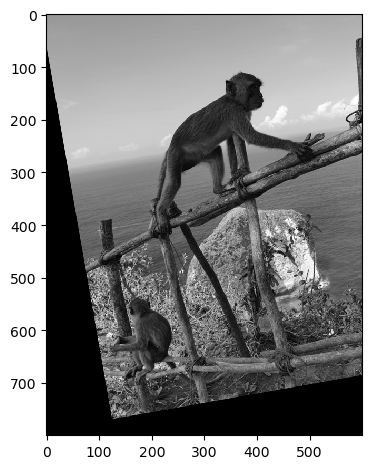

In [9]:
transformed_img = warp(im_org, tform)
io.imshow(transformed_img)

In [10]:
# angle in radians - counter clockwise
rotation_angle = 30.0 * math.pi / 180.
trans = [0, 0]
tform = EuclideanTransform(rotation=rotation_angle, translation=trans)
print(tform.params)

[[ 0.8660254 -0.5        0.       ]
 [ 0.5        0.8660254  0.       ]
 [ 0.         0.         1.       ]]


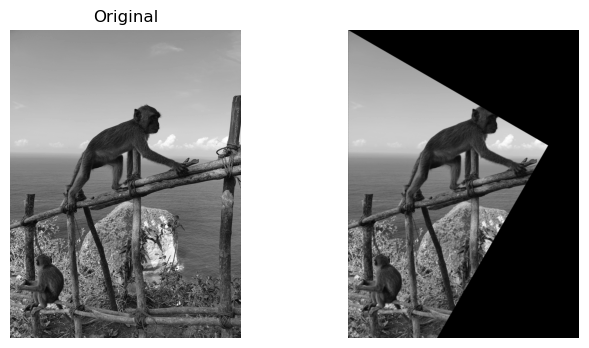

In [11]:
tform_img = warp(im_org, tform)
inv_img = warp(im_org, tform.inverse)
original_img = warp(tform_img, tform.inverse)

show_comparison(im_org, original_img, '')

## Similarity transform of image

The `SimilarityTransform` computes a transformation consisting of a translation, rotation and a scaling. 

### Exercise 9

Define a `SimilarityTransform` with an angle of $15^o$, a translation of (40, 30) and a scaling of 0.6 and test it on the image.

In [12]:
# angle in radians - counter clockwise
rotation_angle = 15.0 * math.pi / 180.
trans = [40, 30]
scale_factor = 0.6
s_tform = SimilarityTransform(rotation=rotation_angle, translation=trans, scale=scale_factor)
print(s_tform.params)

[[ 0.5795555  -0.15529143 40.        ]
 [ 0.15529143  0.5795555  30.        ]
 [ 0.          0.          1.        ]]


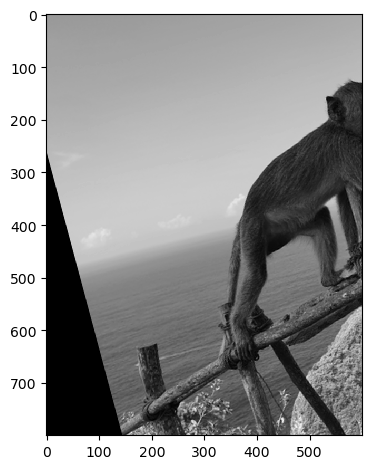

In [13]:
im_tform = warp(im_org, s_tform)
io.imshow(im_tform)

## The swirl image transformation

The **swirl** image transform is a non-linear transform that can create interesting visual results on images.

### Exercise 10

Try the swirl transformation:

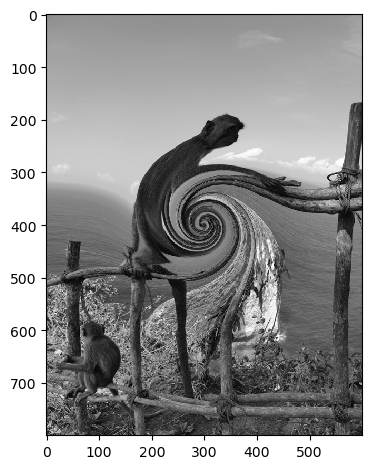

In [14]:
str = 10
rad = 300
swirl_img = swirl(im_org, strength=str, radius=rad)
io.imshow(swirl_img)

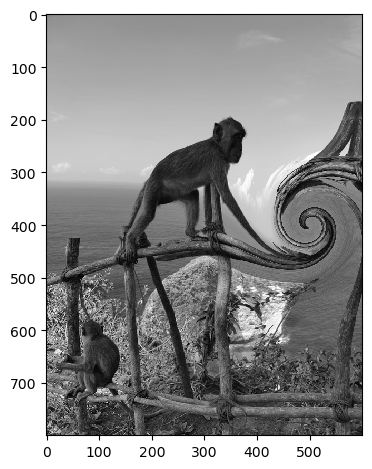

In [15]:
str = 10
rad = 300
c = [500, 400]
swirl_img = swirl(im_org, strength=str, radius=rad, center=c)
io.imshow(swirl_img)

# Landmark based registration

The goal of landmark based registration is to align two images using a set of landmarks placed in both images. The landmarks need to have *correspondence* meaning that the landmarks should be placed on the same anatomical spot in the two images.

There are two photos of hands: **Hand1.jpg** and **Hand2.jpg** and the goal is to transform **Hand1** so it fits on top of **Hand2**. In this exercise we call Hand1 one for the *source* (src) and Hand2 for the *destination* (dst).

### Exercise 11

Start by reading the two images into *src_img* and *dst_img*.

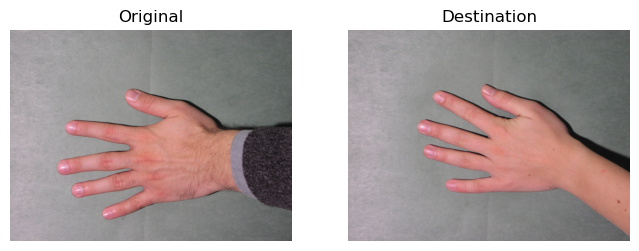

In [16]:
# Directory containing data and images
in_dir = "data/"
src_img = io.imread(in_dir + 'Hand1.jpg')
dst_img = io.imread(in_dir + 'Hand2.jpg')
show_comparison(src_img, dst_img, 'Destination')

## Manual landmark annotation

We will manually placed landmarks on the two images to align the them.

### Exercise 12
We have manually placed a set of landmarks on the source image. They can be visualized by:


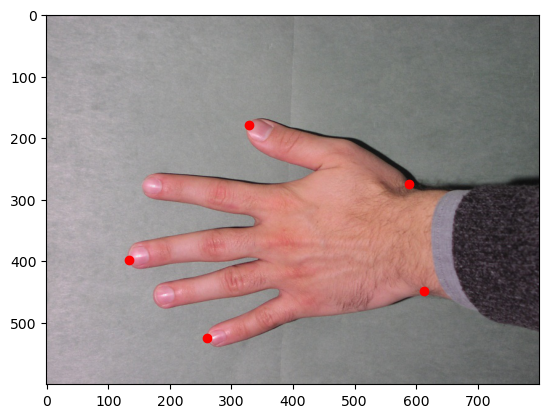

In [17]:
src = np.array([[588, 274], [328, 179], [134, 398], [260, 525], [613, 448]])

plt.imshow(src_img)
plt.plot(src[:, 0], src[:, 1], '.r', markersize=12)
plt.show()

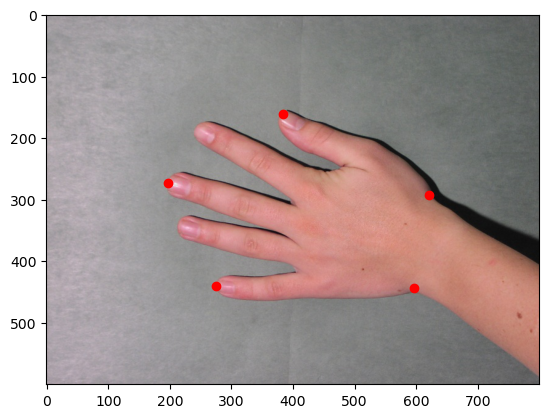

In [18]:
dst = np.array([[620,292], [383,161], [197,273], [275,440], [596,443]])
plt.imshow(dst_img)
plt.plot(dst[:, 0], dst[:, 1], '.r', markersize=12)
plt.show()

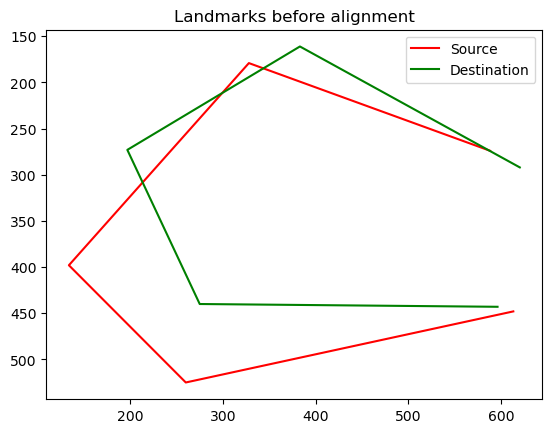

In [23]:
fig, ax = plt.subplots()
ax.plot(src[:, 0], src[:, 1], '-r', markersize=12, label="Source")
ax.plot(dst[:, 0], dst[:, 1], '-g', markersize=12, label="Destination")
ax.invert_yaxis()
ax.legend()
ax.set_title("Landmarks before alignment")
plt.show()

To calculate how well two sets of landmarks are aligned, we can compute the *objective function*:

$$ F = \sum_{i=1}^N \|a_i - b_i\|^2 \enspace ,$$

here $a_i$ are the landmarks in the destination image and $b_i$ are the landmarks in the source image.

### Exercise 14

Compute $F$ from your landmarks. It can for example be done like:

In [24]:
def objective_function_2d(a, b):
    e_x = a[:, 0] - b[:, 0]
    error_x = np.dot(e_x, e_x)
    e_y = a[:, 1] - b[:, 1]
    error_y = np.dot(e_y, e_y)
    return error_x + error_y

In [26]:
f = objective_function_2d(src, dst) 
print(f"Landmark alignment error F: {f}")

Landmark alignment error F: 32055


Optimal Euclidean Transformation

In [33]:
tform = EuclideanTransform()
tform.estimate(src, dst)

s_tform = SimilarityTransform()
s_tform.estimate(src, dst)

src_transform = matrix_transform(src, tform.params)
sim_transform = matrix_transform(src, s_tform.params)

f_trans = objective_function_2d(src_transform, dst)
f_sim = objective_function_2d(sim_transform, dst)
print(f"Landmark alignment error following Euclidean transform: {f_trans}")
print(f"Landmark alignment error following Similarity transform: {f_sim}")

Landmark alignment error following Euclidean transform: 4454.213058442912
Landmark alignment error following Similarity transform: 1419.176046628129


### Exercise 15
Visualize the transformed source landmarks together with the destination landmarks. Also compute the objective function using the transformed points. What do you observe?

The new objective function $F$ is reduced by 86% after Euclidean Transformation. We also observe that the accuracy of transformation is limited by the transformation type. Since the reference points in each image have different scales, they cannot be matched perfectly with a rigid body transformation.

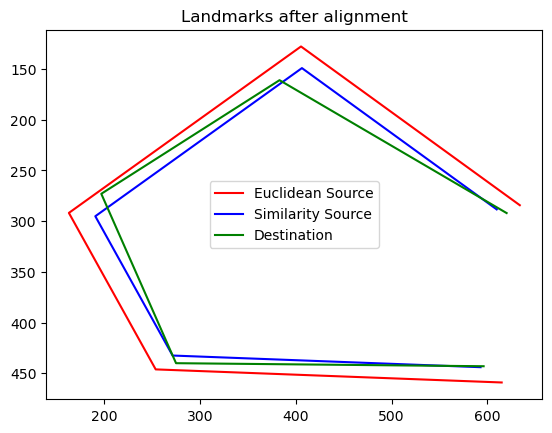

In [35]:
fig, ax = plt.subplots()
ax.plot(src_transform[:, 0], src_transform[:, 1], '-r', markersize=12, label="Euclidean Source")
ax.plot(sim_transform[:, 0], sim_transform[:, 1], '-b', markersize=12, label="Similarity Source")
ax.plot(dst[:, 0], dst[:, 1], '-g', markersize=12, label="Destination")
ax.invert_yaxis()
ax.legend()
ax.set_title("Landmarks after alignment")
plt.show()

### Exercise 16

We can now apply the transformation to the source image. Notice that we use the inverse transform due to the inverse mapping in the image resampling:

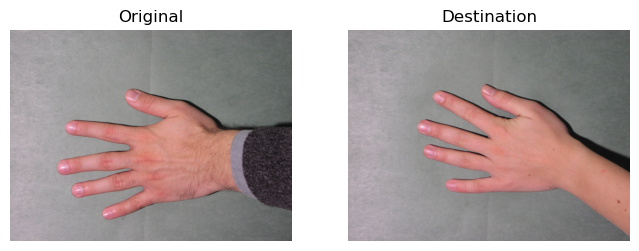

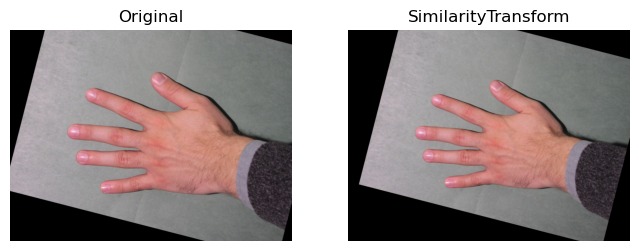

In [37]:
warped = warp(src_img, tform.inverse)
warped_scale = warp(src_img, s_tform.inverse)
show_comparison(src_img, dst_img, 'Destination')
show_comparison(warped, warped_scale, 'SimilarityTransform')